In [28]:
from torchaudio.datasets import LIBRISPEECH
import matplotlib.pyplot as plt
import numpy as np

In [29]:
dataset = LIBRISPEECH(
    root="/media/SSD/datasets",
    url="dev-clean",
    folder_in_archive="LibriSpeech",
    download=False,
)

num_samples = len(dataset)
num_samples

2703

In [30]:
lengths = np.array([w.shape[1] for w, *_ in dataset])

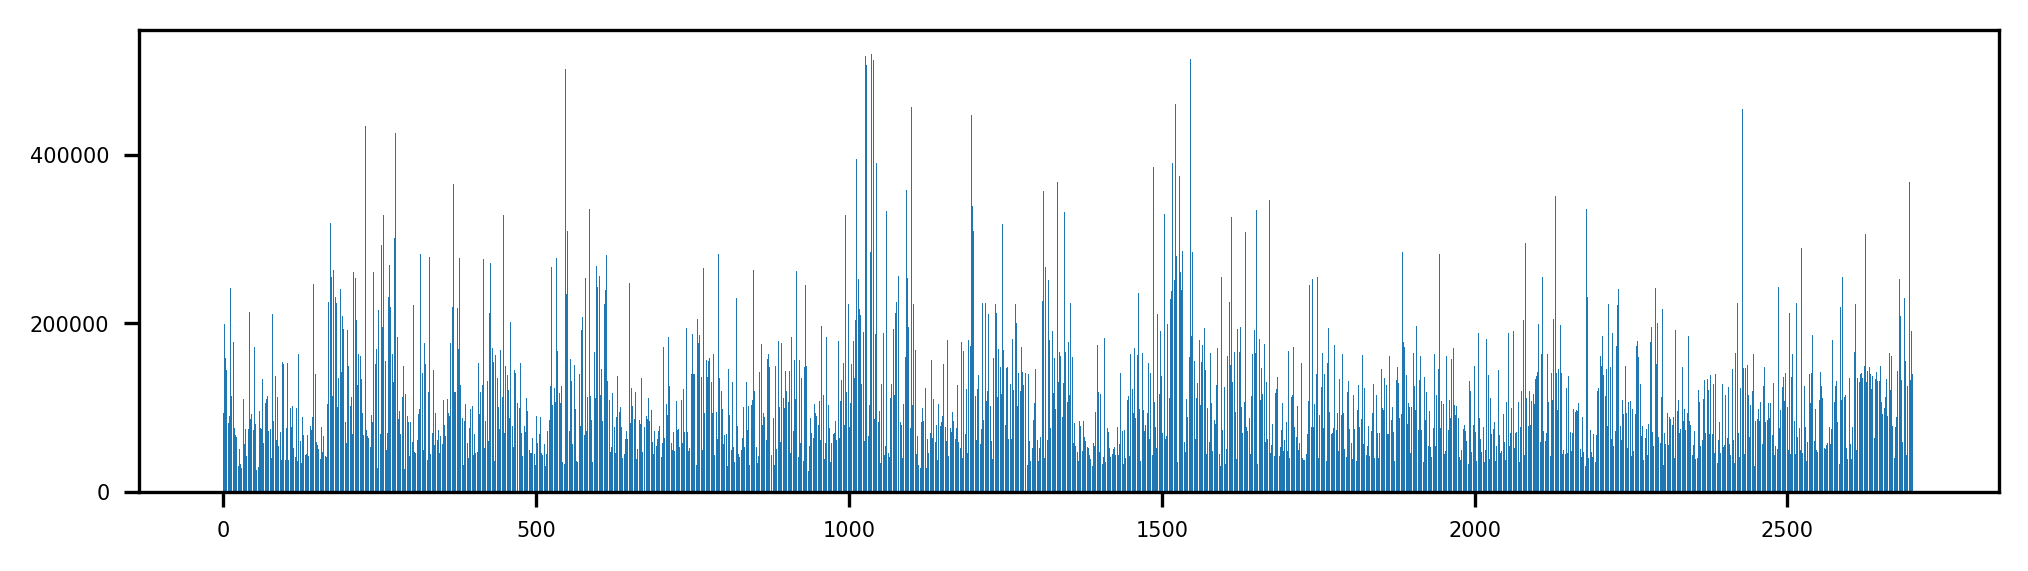

In [31]:
plt.figure(dpi=300, figsize=(8, 2))
plt.bar(range(num_samples), lengths)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.show()

In [32]:
# sort lengths descending
sorted_idxs = np.argsort(lengths)[::-1]
sorted_lengths = lengths[sorted_idxs]

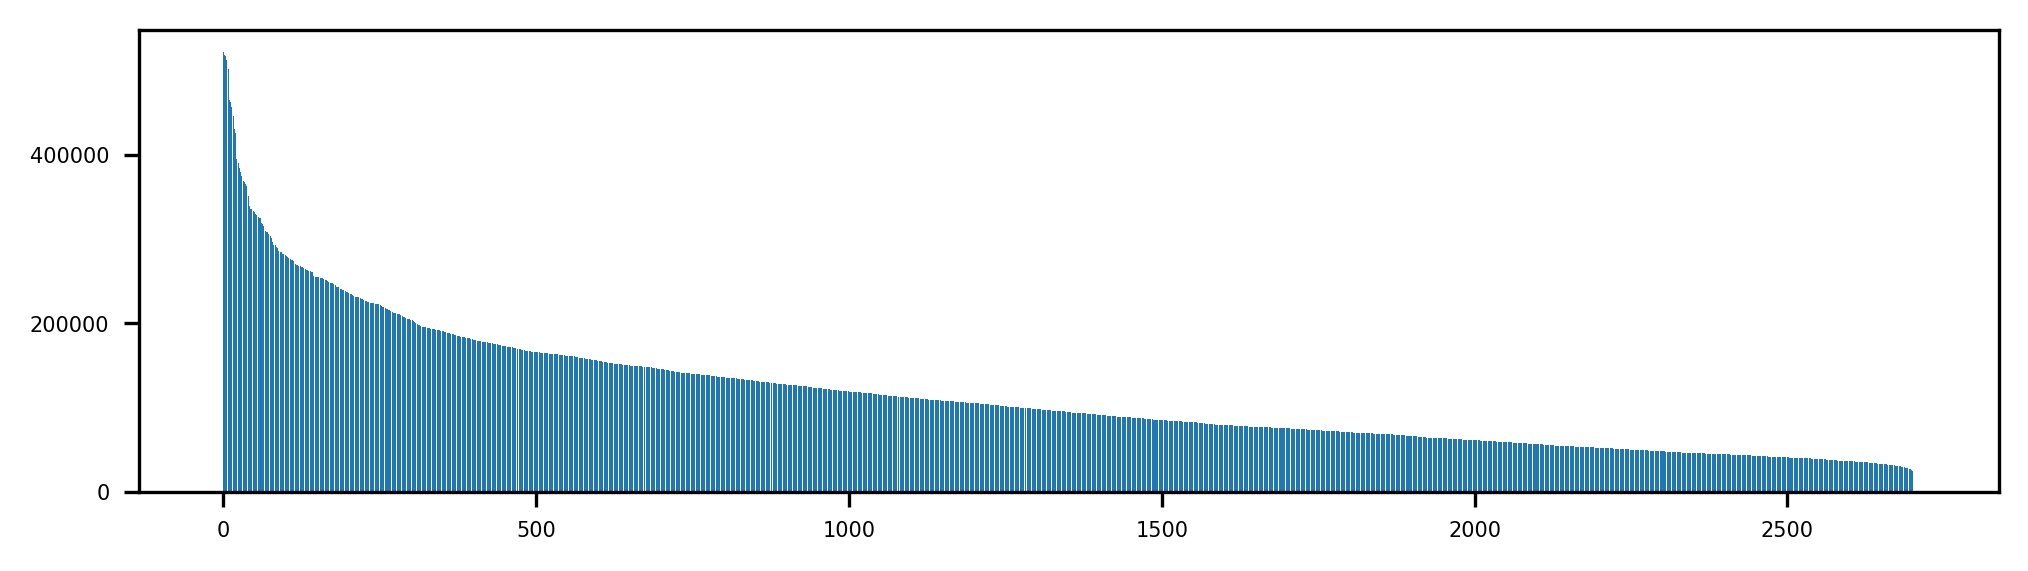

In [33]:
plt.figure(dpi=300, figsize=(8, 2))
plt.bar(range(num_samples), sorted_lengths)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.show()

In [34]:
# find first power of 2 greater than num_samples

N = 2
while N < num_samples:
    N *= 2
N

4096

In [35]:
number_of_chunks = 4

In [36]:
# starting indices if we divide N into number_of_chunks
chunk_size = N // number_of_chunks
starting_indices = np.arange(0, num_samples, chunk_size)
starting_lengths = sorted_lengths[starting_indices]
padded_lengths = (starting_lengths[:,None] + np.zeros((1, chunk_size)).astype(int)).ravel()[:num_samples]

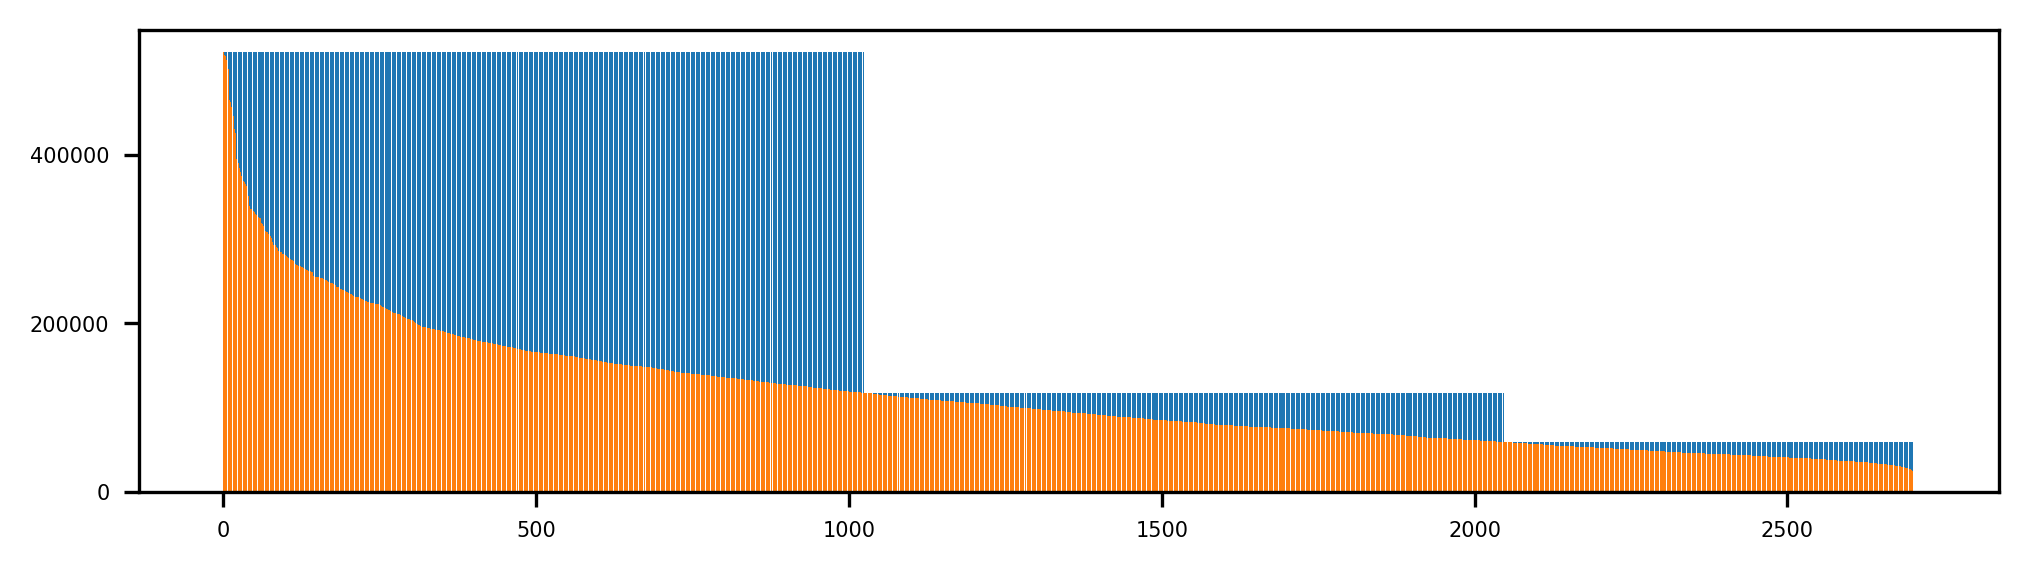

In [37]:
plt.figure(dpi=300, figsize=(8, 2))
plt.bar(range(num_samples), padded_lengths)
plt.bar(range(num_samples), sorted_lengths)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.show()

In [11]:
from torch.utils.data import Dataset

In [38]:
class SortedChunkedDataset(Dataset):
    def __init__(self, dataset, num_chunks, sort_key_fn: lambda item: item):
        self.dataset = dataset
        print("Sorting dataset...")
        lengths = np.array([sort_key_fn(item) for item in dataset])
        print("Done sorting dataset.")
        self.sorted_idxs = np.argsort(lengths)[::-1]
        sorted_lengths = lengths[self.sorted_idxs]
        N = 2
        while N < len(dataset):
            N *= 2
        chunk_size = N // num_chunks
        starting_indices = np.arange(0, len(dataset), chunk_size)
        starting_lengths = sorted_lengths[starting_indices]
        self.padded_lengths = (
            starting_lengths[:, None] + np.zeros((1, chunk_size)).astype(int)
        ).ravel()[: len(dataset)]

    def __getitem__(self, idx):
        return self.dataset[self.sorted_idxs[idx]], self.padded_lengths[idx]

    def __len__(self):
        return len(self.sorted_idxs)

In [39]:
new_dataset = SortedChunkedDataset(dataset, number_of_chunks, lambda item: item[0].shape[1])

Sorting dataset...


Done sorting dataset.


In [40]:
(waveform, *_), pad_length = new_dataset[0]
print(waveform.shape)
print(pad_length)

torch.Size([1, 522320])
522320


In [41]:
(waveform, *_), pad_length = new_dataset[1]
print(waveform.shape)
print(pad_length)

torch.Size([1, 519760])
522320


In [42]:
(waveform, *_), pad_length = new_dataset[2]
print(waveform.shape)
print(pad_length)

torch.Size([1, 519040])
522320


In [43]:
(waveform, *_), pad_length = new_dataset[1023]
print(waveform.shape)
print(pad_length)

torch.Size([1, 117680])
522320


In [44]:
(waveform, *_), pad_length = new_dataset[1024]
print(waveform.shape)
print(pad_length)

torch.Size([1, 117601])
117601
